# pset05: a mixture of five
*by Xingyu (Luna) Li , Oct 12nd, 2021*
  
## Background
Wiggins has performed **single-cell RNA-seqs** on differentiated sand mouse embryonic stem cells,  in which he was looking at two key early transcription factor genes called Caraway and Kiwi. Previous work had shown that Caraway and Kiwi are expressed at intermediate levels in ES cells, but upon differentiation, their mRNA expression patterns break into four different cell types with all four possible combinations of low vs. high expression of these two TFs.  

He had collected mapped read counts for Caraway and Kiwi in 1000 single differentiated ES cells and used **K-means clustering, with K=5**, to try to assign each cell to one of the five cell types, and thus estimate the mean expression level (in mapped counts) of the two genes in each cell type, and the relative proportions of the cell types in the population.  
  
  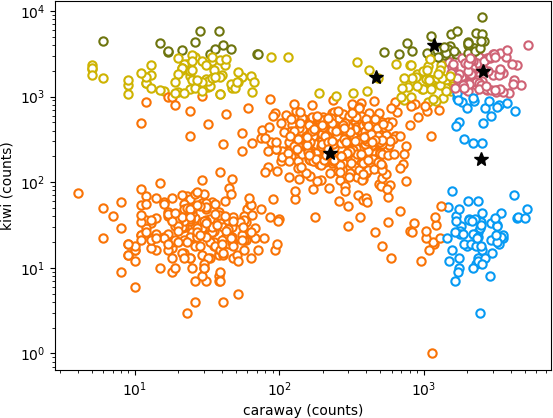
   
However, compared to the true cell types labeled in his data, the clustering seems to fail. I decide to have a look at it.

## 1. Reproduce Wiggins' K-means Result

First, I am going to perform a standard K-means clustering procedure to cluster Wiggins' data into K=5 clusters, run the K-means algorithm multiple times and choose the best.  


In [1]:
# Read the data
import numpy as np
import random as rd
import matplotlib.pyplot as plt

def read_data(infile):
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])]) 
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

ctype, data, N, G, Q = read_data("w05-data.tbl")

In [2]:
data

array([[ 362,  407],
       [  42,   61],
       [3297,  787],
       ...,
       [  28,   24],
       [  22,   13],
       [  19,   44]])

In [2]:
# Calculate Euclidean distance
def Euclidean(x1,x2):
    dimension = len(x1)
    dist = 0.0
    for i in range(dimension):
        dist += (x1[i] - x2[i]) ** 2
    return np.sqrt(dist)

# K-means clustering 
def k_means(data, K):
    
    # select random centroid for each cluster (choose from X)
    centroids = data[np.random.choice(data.shape[0], K, replace=False)]
    # initialize the labels, the two labels lists are different so the iteration could begin
    labels = [-1]*len(data)
    New_labels = [-2]*len(data)
    # initialize the clusters
    C = []
    for i in range(K):
        C.append([])

    # iterate until the assignments of each item to the clusters do not change
    while(labels != New_labels):
        labels = list(New_labels)
        
        # iterate through each item to assign them to a cluster
        for labelIndex, item in enumerate(data):
            classIndex = -1    # initialize class index to be -1
            minDist = float('inf')    # set to infinity so that each item assigns to a cluster at the begining
            # iterate through each centroids to assign item to a cluster
            for i, point in enumerate(centroids):
                dist = Euclidean(item, point) # calculate the Euclidean distance between item and centroids
                if(dist < minDist):       # if the new distance is less than the previous one, 
                    classIndex = i        # assign that point to the new cluster
                    minDist = dist        # and update the distance
            C[classIndex].append(item)    # store the item in that cluster
            New_labels[labelIndex] = classIndex # and store the label
            
        # iterate through each cluster to calculate the new mean
        tot_sqdist = 0  # intialize the total squared distance
        for i, cluster in enumerate(C):
            clustermean = np.zeros(len(data[0])) # intialize the cluster mean
            for item in cluster:
                for j, coordinate in enumerate(item):
                    clustermean[j] += coordinate / len(cluster) # calculate the mean of each cluster
                    tot_sqdist += np.square(coordinate - clustermean[j])
            centroids[i] = clustermean  # update the centroid
    return C, labels, centroids, tot_sqdist

In [3]:
# Run K-means clustering to cluster Wiggins' data into K = 5 clusters for 20 times

# Find the lowest total squared distance and return the result
def lowest_sqdist(times):
    tot_sqdist_list = []  # initialize the lists
    labels_list = []
    centroids_list = []
    for i in range(times): # add each result to the list
        C, labels, centroids, tot_sqdist = k_means(data, 5)
        tot_sqdist_list.append(tot_sqdist)
        labels_list.append(labels)
        centroids_list.append(centroids)
    # Choose the clustering result with the lowest total squared distance
    labels = labels_list[np.argmin(tot_sqdist_list)]
    centroids = centroids_list[np.argmin(tot_sqdist_list)]
    return labels,centroids

labels,centroids = lowest_sqdist(times = 20)

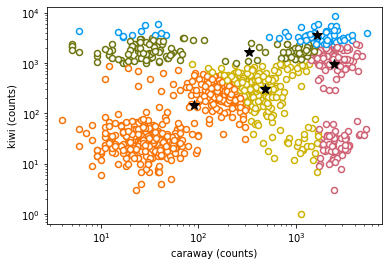

In [4]:
# Visualize the best K-means clustering results
def visualize_data(data, centroids, labels, outpng):
    N, G  = np.shape(data)
    Q, G2 = np.shape(centroids)
    assert G == G2
    assert len(labels) == N
    # assign colors to up to Q=10 components
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']
    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[labels[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)
    for q in range(Q):
        ax.loglog(centroids[q,0], centroids[q,1], '*k', ms=10)
    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')
    fig.savefig(outpng)
    
visualize_data(data, centroids, labels, "outpng")

We can see from our visualization, even though we have run the K-means algorithm multiple (20) times and choose the best with the lowest total squared distance, it could not assign each points to its cluster correctly.  
The reason behind this is that k-means is a **local optimum**.  
  
K-means can be seen as a special version of the EM algorithm, if the parameters 𝜇𝑖 are known, we can assign each point 𝑝 its maximum likelihood cluster. We can find a best solution (a global one) by integrating over all possible assignments of points to clusters, but the number of iterations would be exponential in the size of our data, which unfeasible to calculate. 
  
Instead, we can take some guess as to the hidden parameters and iterate the two steps (with the posibility of ending up in a local maximum). If we allow each cluster to take a partial responsibility for a point, we end up with EM, if we just assign the optimal cluster, we get k-means.

## 2. Mixture Negative Binomial Fitting

Our standard K-means could be improved by assigning each point to a cluster using probability models rather than fixed hard assignments. Moreover, we can use a generative probability model composed of many probability distributions, i.e., a **mixture model**.

Since we want to model the observed counts of our single-cell RNA-seq experiments directly, like pulling balls out of urns with finite sampling error. Therefore, the **negative binomial distribution** would be a good choice, which models the number of successes in a sequence of independent and identically distributed Bernoulli trials before a specified number of failures occurs.

We are going to use the expectation maximization (EM) algorithm to fit our model with hidden variables, which can be devided to two steps: the Expectation step and the Maximization step.  
  
First, for the **Expectation step**:

In [5]:
# Calculate the posterior probability for each data point coming from each component
import scipy.stats as stats

# Define a log-sum-exp function to avoid underflow when normalizing
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))

# Calculate the posterior probabilities and assignments
def expectation(data, centroids, phi, mix_coeffs):
    logpqx_num = np.asarray([ [0.0]*len(centroids) for i in range(len(data))]) 
    logpqx = np.asarray([ [0.0]*len(centroids) for i in range(len(data))]) # intialize the log P(q|x)
    
    # Loop through points
    for i,point in enumerate(data): 
        # Append the log probability that the point is generated by each component: log(π * P(x|θ_q))
        for k,centroid in enumerate(centroids):
            for j, coordinate in enumerate(point):
                logpqx_num[i][k] += stats.nbinom.logpmf(coordinate, n = 1/phi, p = 1/(1+centroid[j]*phi)) 
                + np.log(mix_coeffs[k])
    
    # Obtain the normalized log posterior probability that each data point comes from each component
    for i in range(len(data)):
        for k in range(len(centroids)):
            logpqx[i][k] = logpqx_num[i][k]-logsumexp(logpqx_num[i])
    
    # Assign clusters based on max posterior probability
    clusters = [np.argmax(logpqx[i]) for i in range(len(data))]
    
    return logpqx, clusters

Next is the **Maximization step**, where we update the centroids and mixture coefficient given the posterior probabilities.

In [6]:
# Calculate the new centroids and mixture coefficients for each component
def maximization(data, logpqx, mix_coeffs):
    
    # calculate the new mean for each component q as the posterior weighted average of point positions 

    logmu_num = np.asarray([ [0.0]* G for i in range(len(mix_coeffs))]) # intialize the log of mean numerater
    logmu_denom = np.asarray([ [0.0]* G for i in range(len(mix_coeffs))]) # intialize the log of mean denominator
    logweightedcoor = np.asarray([ [0.0]* len(data) for i in range(G)]) # intialize the log of weighted coordinates of each point
    logpqx_t = np.asarray([ [0.0]* len(data) for i in range(G)]) # intialize the log of transposed P(q|x)
    
    # first calculate the (log of) numerator    
    for k in range(len(mix_coeffs)):    
        for i,point in enumerate(data): 
            for j, coordinate in enumerate(point):
                logweightedcoor[j][i] = logpqx[i][k] + np.log(coordinate)
        for j, coordinate in enumerate(point):
            logmu_num[k][j] = logsumexp(logweightedcoor[j])
    
    # then calculate the (log of) denominator
    for k in range(len(mix_coeffs)):    
        for i,point in enumerate(data): 
            for j, coordinate in enumerate(point):
                logpqx_t[j][i] = logpqx[i][k]
        for j, coordinate in enumerate(point):
            logmu_denom[k][j] = logsumexp(logpqx_t[j])
                
    # divide the numerator by denominator to get the weighted means
    centroids = np.exp(logmu_num - logmu_denom)

    # calculate the new mixture coefficients as the mean of the posteriors
    for k in range(len(centroids)): 
        mix_coeffs[k] = np.exp(sum(logmu_denom[k]))
    mix_coeffs = mix_coeffs/len(data)
    
    return centroids, mix_coeffs

We would then use **log-likelihood** to compare the models and choose the one that has the highest likelihood (the smallest negative log-likelihood).

In [7]:
# Return the negative log likelihood of data given the current mixture model
def negll(data, centroids, phi, mix_coeffs):
    # Initialize the parameters
    logprob = np.zeros(len(centroids))
    ll_q = np.zeros(len(data))

    # Compute the nll as the logpmf of the data, given mu and sigma, plus the log of the mixture coefficient
    for i,point in enumerate(data): 
        for k,centroid in enumerate(centroids):
            for j, coordinate in enumerate(point):
                logprob[k] += stats.nbinom.logpmf(coordinate, n = 1/phi, p = 1/(1+centroid[j]*phi))
                + np.log(mix_coeffs[k])
        ll_q[i] = logsumexp(logprob)
        
    # Summed for each point
    ll = sum(ll_q)
     
    return -ll

Finally, we will set our parameters and iterate our algorithm to find the model with the largest likelihood to be our final clustering results.

In [13]:
# Iterate to obtain a model with the largest likelihood

# Define number of times to run the EM algorithm, number of clusters, and dispersion
n_runs = 20
num_clust = 5
phi = 0.3
# Define a threshold for nll change that will stop iteration (nll_thresh)
nll_thresh = .001

# Define best centroids, best distance to centroid, best mixture coefficients and intialize as starting best nll
min_dist = float('inf')
centroids_best = []*len(data)
nll_best = float('inf')
mix_coeffs_best = []

for i in range(n_runs):
    
    # Each iteration starts with a random set of centroids with random mixture coeffcients
    mix_coeffs = np.random.rand(num_clust)
    mix_coeffs = np.divide(mix_coeffs,sum(mix_coeffs))
    centroids = data[np.random.choice(data.shape[0], num_clust, replace=False)]
    
    # Iterate until the nll stops changing
    # Initialize holder variables for the last nll and the difference between the current and last nll
    nll_diff = float('inf')
    nll_old = float(0)    
    
    # Iterate while the differnece between consecutive nlls is above a threshold
    while nll_diff > (nll_thresh * abs(nll_old)):
        
        # Calculate posterior probabilities and assign points to clusters
        posts,clusters = expectation(data, centroids, phi, mix_coeffs)
        
        # Calculate new mus and mixture coefficients given current posterior probabilities
        centroids, mix_coeffs = maximization(data, posts, mix_coeffs)    
        
        # Calcualte the nll of hte current mixture model
        nll = negll(data, centroids, phi, mix_coeffs) 
         
        # Find difference in consecutive nlls and update the nll_old
        nll_diff = abs(nll-nll_old)
        nll_old = nll
        
        # Update best estimates for mus, mixture coefficients and cluster assignments
        if nll < nll_best:
            mix_coeffs_best = mix_coeffs
            nll_best = nll
            centroids_best = centroids
            clusters_best = clusters

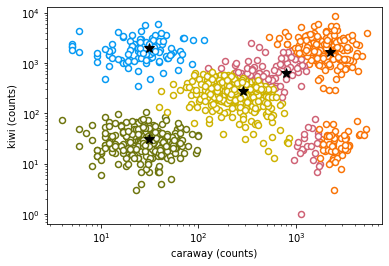

In [14]:
# Visualize the results
visualize_data(data, centroids_best, clusters_best, "outpng_NB")

In [15]:
# Calculate the mean expression levels for each cluster
import pandas as pd
data_pd = pd.DataFrame(data, columns = ['Caraway','Kiwi'])
data_pd['cluster'] = clusters_best
data_pd.groupby('cluster').mean()

,Caraway,Kiwi
cluster,,
0,2257.137168,1672.061947
1,31.086580,31.138528
2,30.625000,1993.145833
3,768.906250,625.145833
4,283.746439,279.481481


In [16]:
# Calculate the relative proportions of each cell type
data_pd['cluster'].value_counts()/len(data_pd)

4    0.351
1    0.231
0    0.226
2    0.096
3    0.096
Name: cluster, dtype: float64

For most times, the negative binomial mixture model clusters the majority of our RNA-seq reads successfully, however, like k-means, the expectation maximization algorithm is also a local optimizer. Although we iterate it many times and try to find the best one with the largest log likelihood (lowest negative log likelihood) among them, there is no guarantee that we will get the clustering right every time.

## 3. Find a Simple Fix for K-means

When applying a standard K-means clustering algorithm to Wiggins' single cell RNA-seq data, the results are not that good.  

A possible reason why our k-means clustering fails is that our data may violate many assumptions behind it, one of them would be that they are drawn from a Gaussian distribution. However, the RNA-seq data are often **positive skewed** with a tail on the right, since there may be some RNAs with really high expressions.
  
Therefore, a simple fix for our k-means model would just be **taking the log of our RNA counts**, so that it can be transformed to a more 'normal' distribution.

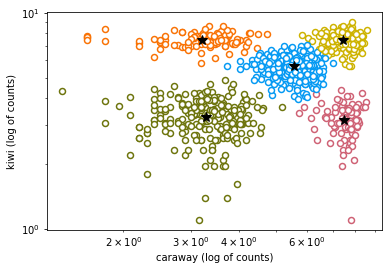

In [12]:
# Run K-means clustering to cluster log of our data into K = 5 clusters for 20 times

# Find the lowest total squared distance and return the result
def lowest_sqdist(times):
    tot_sqdist_list = []  # initialize the lists
    labels_list = []
    centroids_list = []
    for i in range(times): # add each result to the list
        C, labels, centroids, tot_sqdist = k_means(np.log(data), 5)
        tot_sqdist_list.append(tot_sqdist)
        labels_list.append(labels)
        centroids_list.append(centroids)
    # Choose the clustering result with the lowest total squared distance
    labels = labels_list[np.argmin(tot_sqdist_list)]
    centroids = centroids_list[np.argmin(tot_sqdist_list)]
    return labels,centroids

labels,centroids = lowest_sqdist(times = 20)

# Visualize the best K-means clustering results
def visualize_log_data(data, centroids, labels, outpng):
    N, G  = np.shape(data)
    Q, G2 = np.shape(centroids)
    assert G == G2
    assert len(labels) == N
    # assign colors to up to Q=10 components
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']
    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[labels[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)
    for q in range(Q):
        ax.loglog(centroids[q,0], centroids[q,1], '*k', ms=10)
    ax.set_xlabel('caraway (log of counts)')
    ax.set_ylabel('kiwi (log of counts)')
    fig.savefig(outpng)
    
visualize_log_data(np.log(data), centroids, labels, "outpng_log")

We can tell from the figure above that our simple fix of taking a log of our RNA-seq data works pretty well, each points are assigned to its cluster correctly. 